In [1]:
import os
import numpy as np
import cv2
import torch
import random
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim


C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# # ---------------------- Hyperparameters ----------------------
# config = wandb.config
IMG_SIZE = 64
num_epochs = 100
batch_size = 32
learning_rate = 0.0007723
weight_decay = 0.002453
filters1 = 16
filters2 = 64
filters3 = 128
filters4 = 256
dropout_rate = 0.4986
num_layers = 4
regularization = 0.09765 # L2 regularization weight

dataset_root = r"Cropped_ROIs_V0.47_Split\train_by_class" # <-- Your dataset path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:

# Check dataset directory
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset directory '{dataset_root}' does not exist.")


# Ensure IMG_SIZE is compatible with num_layers
if IMG_SIZE % (2 ** num_layers) != 0:
    raise ValueError(f"IMG_SIZE ({IMG_SIZE}) must be divisible by 2^{num_layers}")

# ---------------------- Albumentations Transforms ----------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.CLAHE(clip_limit=2.0, p=0.3),
    A.OneOf([
        A.MotionBlur(p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    ], p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])


c:\Users\USER\miniconda3\envs\LSS\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\USER\AppData\Local\Temp\ipykernel_48792\3834101287.py:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [4]:

# ---------------------- Dataset ----------------------
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for label_str in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label_str)
            if os.path.isdir(label_dir):
                try:
                    label = int(label_str)
                except ValueError:
                    raise ValueError(f"Folder name '{label_str}' is not a valid class label. Use numeric folder names.")
                for filename in os.listdir(label_dir):
                    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                        self.samples.append((os.path.join(label_dir, filename), label))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.equalizeHist(img)
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0
        return img, torch.tensor(label, dtype=torch.long)

dataset_full = ImageFolderDataset(dataset_root)
indices = list(range(len(dataset_full)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(dataset_full, train_idx)
val_dataset = Subset(dataset_full, val_idx)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [5]:
# ---------------------- Model ----------------------
class FlexibleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(1, filters1, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(filters1)
        
        self.conv2 = nn.Conv2d(filters1, filters2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters2)

        self.additional_layers = nn.ModuleList()
        in_channels = filters2

        if num_layers >= 3:
            self.conv3 = nn.Conv2d(in_channels, filters3, 3, padding=1)
            self.bn3 = nn.BatchNorm2d(filters3)
            in_channels = filters3
        else:
            self.conv3 = None

        if num_layers >= 4:
            self.conv4 = nn.Conv2d(in_channels, filters4, 3, padding=1)
            self.bn4 = nn.BatchNorm2d(filters4)
            in_channels = filters4
        else:
            self.conv4 = None

        self.dropout = nn.Dropout(dropout_rate)

        flatten_size = (IMG_SIZE // (2 ** num_layers)) ** 2 * in_channels
        self.fc1 = nn.Linear(flatten_size, 32)
        self.fc2 = nn.Linear(32, num_classes)

        # L2 regularization weight for FC layer
        self.fc_regularization =regularization

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        if self.conv3:
            x = self.pool(F.relu(self.bn3(self.conv3(x))))
        if self.conv4:
            x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = FlexibleCNN().to(device)


# ---------------------- Loss and Optimizer ----------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion = FocalLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)



In [6]:


best_val_accuracy = 0.0
best_epoch = 0

# ---------------------- Training ----------------------
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Add FC regularization loss
        l2_fc = 0
        for param in model.fc1.parameters():
            l2_fc += torch.sum(param ** 2)
        loss += regularization * l2_fc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1

        # Optional: save best model
        torch.save(model.state_dict(), "best_model_hyper_parameters.pth")
        print("best_model by optomize the hyper_parameters")



    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

C:\Users\USER\AppData\Local\Temp\ipykernel_48792\3264298380.py:22: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  total_train_loss += loss.item()


best_model by optomize the hyper_parameters
Epoch 1 | Train Loss: 0.8540 | Val Loss: 0.3310 | Val Accuracy: 68.55%
best_model by optomize the hyper_parameters
Epoch 2 | Train Loss: 0.4650 | Val Loss: 0.3095 | Val Accuracy: 69.60%
best_model by optomize the hyper_parameters
Epoch 3 | Train Loss: 0.3940 | Val Loss: 0.3113 | Val Accuracy: 70.23%
best_model by optomize the hyper_parameters
Epoch 4 | Train Loss: 0.3783 | Val Loss: 0.3048 | Val Accuracy: 70.86%
best_model by optomize the hyper_parameters
Epoch 5 | Train Loss: 0.3563 | Val Loss: 0.3155 | Val Accuracy: 71.07%
best_model by optomize the hyper_parameters
Epoch 6 | Train Loss: 0.3601 | Val Loss: 0.3017 | Val Accuracy: 72.54%
Epoch 7 | Train Loss: 0.3667 | Val Loss: 0.2897 | Val Accuracy: 72.12%
Epoch 8 | Train Loss: 0.3475 | Val Loss: 0.2909 | Val Accuracy: 72.54%
best_model by optomize the hyper_parameters
Epoch 9 | Train Loss: 0.3451 | Val Loss: 0.2882 | Val Accuracy: 73.17%
Epoch 10 | Train Loss: 0.3303 | Val Loss: 0.3326 | Va

In [ ]:
# # ---------------------- Training ----------------------
# for epoch in range(num_epochs):
#     model.train()
#     total_train_loss = 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Add FC regularization loss
#         l2_fc = 0
#         for param in model.fc1.parameters():
#             l2_fc += torch.sum(param ** 2)
#         loss += regularization * l2_fc

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_train_loss += loss.item()

#     avg_train_loss = total_train_loss / len(train_loader)

#     # ---------------------- Validation ----------------------
#     model.eval()
#     total_val_loss = 0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             val_loss = criterion(outputs, labels)
#             total_val_loss += val_loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     avg_val_loss = total_val_loss / len(val_loader)
#     val_accuracy = 100 * correct / total

#     print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

# # ---------------------- Save Final Model ----------------------
# torch.save(model.state_dict(), "final_model_3.pth")
# print("Final model saved.")


Epoch 1 | Train Loss: 1.1479 | Val Loss: 0.4420 | Val Accuracy: 40.43%
Epoch 2 | Train Loss: 0.6511 | Val Loss: 0.3744 | Val Accuracy: 52.13%
Epoch 3 | Train Loss: 0.5374 | Val Loss: 0.3703 | Val Accuracy: 55.32%
Epoch 4 | Train Loss: 0.4681 | Val Loss: 0.3469 | Val Accuracy: 56.38%
Epoch 5 | Train Loss: 0.4669 | Val Loss: 0.3260 | Val Accuracy: 62.23%
Epoch 6 | Train Loss: 0.4272 | Val Loss: 0.3047 | Val Accuracy: 67.02%
Epoch 7 | Train Loss: 0.3787 | Val Loss: 0.3074 | Val Accuracy: 63.30%
Epoch 8 | Train Loss: 0.3668 | Val Loss: 0.3297 | Val Accuracy: 55.85%
Epoch 9 | Train Loss: 0.3593 | Val Loss: 0.2960 | Val Accuracy: 62.23%
Epoch 10 | Train Loss: 0.3496 | Val Loss: 0.3068 | Val Accuracy: 57.98%
Epoch 11 | Train Loss: 0.3368 | Val Loss: 0.2976 | Val Accuracy: 62.23%
Epoch 12 | Train Loss: 0.3236 | Val Loss: 0.3362 | Val Accuracy: 51.06%
Epoch 13 | Train Loss: 0.3180 | Val Loss: 0.2946 | Val Accuracy: 55.32%
Epoch 14 | Train Loss: 0.3091 | Val Loss: 0.2744 | Val Accuracy: 66.49%
E

In [7]:
# === Load the best model ===
model = FlexibleCNN().to(device)
model.load_state_dict(torch.load("best_model_hyper_parameters.pth", map_location=device))
model.eval()

# === Prediction Function ===
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = cv2.equalizeHist(img)
    
    transform = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])
    
    img_tensor = transform(image=img)["image"].unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()


#  predicted_label = predict_image(os.path.join(image_folder,i))

In [8]:
path = r"Cropped_ROIs_V0.47_Split\test_by_class" # <- Replace with your actual image
true_pred = 0
False_pred = 0
for label in os.listdir(path):
    image_folder = os.path.join(path, label)
    for i in os.listdir(image_folder):
        
        predicted_label = predict_image(os.path.join(image_folder,i))
        if predicted_label == int(label):
            true_pred +=1
        else:
            False_pred +=1

accuracy = true_pred / (true_pred+False_pred)
print(accuracy)

0.7483221476510067


Accuracy: 0.7483221476510067
Confusion Matrix:
 [[361  49   8   0]
 [ 32  39  20   0]
 [  8  18  24   2]
 [  0   0  13  22]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9002    0.8636    0.8816       418
           1     0.3679    0.4286    0.3959        91
           2     0.3692    0.4615    0.4103        52
           3     0.9167    0.6286    0.7458        35

    accuracy                         0.7483       596
   macro avg     0.6385    0.5956    0.6084       596
weighted avg     0.7736    0.7483    0.7583       596

Specificity per class:
Class 0: 0.7753
Class 1: 0.8673
Class 2: 0.9246
Class 3: 0.9964


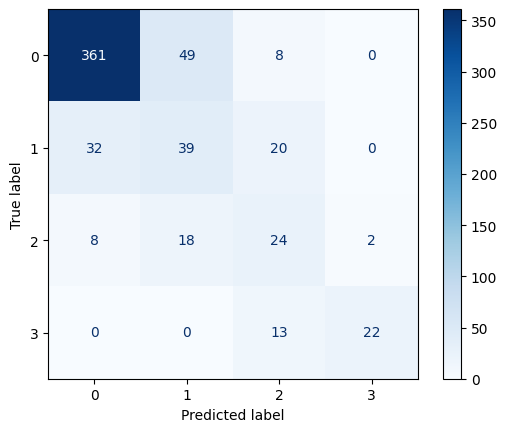

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

path = r"Cropped_ROIs_V0.47_Split\test_by_class"

y_true = []
y_pred = []

for label in os.listdir(path):
    image_folder = os.path.join(path, label)
    for i in os.listdir(image_folder):
        img_path = os.path.join(image_folder, i)
        predicted_label = predict_image(img_path)
        y_true.append(int(label))
        y_pred.append(predicted_label)

# Calculate accuracy
accuracy = sum([1 for t, p in zip(y_true, y_pred) if t == p]) / len(y_true)
print("Accuracy:", accuracy)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
print("Confusion Matrix:\n", cm)

# Classification report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=[0, 1, 2,3], digits=4))

# Specificity calculation for each class
specificity = {}
for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))  # sum all except row i and col i
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])  # sum col i except row i
    specificity[i] = tn / (tn + fp) if (tn + fp) > 0 else 0

print("Specificity per class:")
for k, v in specificity.items():
    print(f"Class {k}: {v:.4f}")

# Optional: Display confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2,3])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [11]:
import os
import numpy as np
import cv2
import torch
import random
import copy
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------------------- Hyperparameters ----------------------
IMG_SIZE = 64
num_epochs = 100
batch_size = 32
learning_rate = 0.0007723
weight_decay = 0.002453
dropout_rate = 0.5     # Increased slightly for better regularization
regularization = 0.01  # L2 regularization weight

# Early Stopping Parameters
patience = 10          # Stop if no improvement after 10 epochs

dataset_root = r"Cropped_ROIs_V0.47_Split\train_by_class" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset directory '{dataset_root}' does not exist.")

# ---------------------- Transforms ----------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# ---------------------- Dataset ----------------------
class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.targets = [] # We need this separate list for the Sampler
        self.transform = transform
        
        # Ensure consistent class ordering
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: int(cls_name) for cls_name in self.classes}

        for label_str in self.classes:
            label_dir = os.path.join(root_dir, label_str)
            label = self.class_to_idx[label_str]
            for filename in os.listdir(label_dir):
                if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    path = os.path.join(label_dir, filename)
                    self.samples.append((path, label))
                    self.targets.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if img is None: # Safety check
            img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)
            
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.equalizeHist(img)
        
        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        else:
            img = torch.tensor(img, dtype=torch.float32).unsqueeze(0) / 255.0
            
        return img, torch.tensor(label, dtype=torch.long)

# Load Data
dataset_full = ImageFolderDataset(dataset_root)

# Split indices
train_idx, val_idx = train_test_split(list(range(len(dataset_full))), test_size=0.2, random_state=42, stratify=dataset_full.targets)

# Create Subsets
train_dataset = Subset(dataset_full, train_idx)
val_dataset = Subset(dataset_full, val_idx)

# Assign Transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform # Important: Use Val transform for Val set!

# --- FIX IMBALANCE: WeightedRandomSampler ---
# 1. Get all labels for the training set
y_train_indices = train_dataset.indices
y_train = [dataset_full.targets[i] for i in y_train_indices]

# 2. Count class occurrences
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])

# 3. Create Sampler
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

print(f"Class Counts in Train: {dict(Counter(y_train))}")

# 4. DataLoaders (Note: shuffle=False when using sampler)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ---------------------- Model ----------------------
class FlexibleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # Simplified Architecture to reduce Overfitting risk
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2)
        )
        
        # Calculate flatten size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, IMG_SIZE, IMG_SIZE)
            out = self.features(dummy)
            flatten_size = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(flatten_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = FlexibleCNN().to(device)

# ---------------------- Loss & Optimizer ----------------------
# ---------------------- Loss & Optimizer ----------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

criterion = FocalLoss(gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# FIX: Removed 'verbose=True' which causes the crash in new PyTorch versions
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ---------------------- Training Loop with Early Stopping ----------------------
best_val_loss = float('inf')
epochs_no_improve = 0

print("Starting Training...")

for epoch in range(num_epochs):
    # --- TRAIN ---
    model.train()
    train_loss_accum = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Manual L2 Regularization on FC layer (Optional, AdamW already does this globally)
        l2_reg = torch.tensor(0., device=device)
        for param in model.classifier.parameters():
            l2_reg += torch.norm(param)
        loss += regularization * l2_reg

        loss.backward()
        optimizer.step()
        train_loss_accum += loss.item()

    avg_train_loss = train_loss_accum / len(train_loader)

    # --- VALIDATE ---
    model.eval()
    val_loss_accum = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_accum += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss_accum / len(val_loader)
    val_accuracy = 100 * correct / total
    
    # --- LOGGING & CHECKS ---
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {val_accuracy:.2f}%")
    
    scheduler.step(avg_val_loss)

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model_balanced.pth")
        print(f"--> Best Model Saved (Val Loss: {avg_val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"--> No improvement for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print("Early Stopping Triggered!")
            break


c:\Users\USER\miniconda3\envs\LSS\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\USER\AppData\Local\Temp\ipykernel_48792\553595245.py:43: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


Class Counts in Train: {0: 1273, 2: 162, 1: 333, 3: 138}
Starting Training...
Epoch 1/100 | Train Loss: 0.6936 | Val Loss: 0.3603 | Acc: 66.04%
--> Best Model Saved (Val Loss: 0.3603)
Epoch 2/100 | Train Loss: 0.5505 | Val Loss: 0.3210 | Acc: 66.67%
--> Best Model Saved (Val Loss: 0.3210)
Epoch 3/100 | Train Loss: 0.4986 | Val Loss: 0.3331 | Acc: 70.44%
--> No improvement for 1 epochs.
Epoch 4/100 | Train Loss: 0.4614 | Val Loss: 0.2942 | Acc: 73.58%
--> Best Model Saved (Val Loss: 0.2942)
Epoch 5/100 | Train Loss: 0.4168 | Val Loss: 0.3353 | Acc: 66.25%
--> No improvement for 1 epochs.
Epoch 6/100 | Train Loss: 0.4131 | Val Loss: 0.3821 | Acc: 68.34%
--> No improvement for 2 epochs.
Epoch 7/100 | Train Loss: 0.3691 | Val Loss: 0.2953 | Acc: 72.54%
--> No improvement for 3 epochs.
Epoch 8/100 | Train Loss: 0.3614 | Val Loss: 0.4251 | Acc: 65.62%
--> No improvement for 4 epochs.
Epoch 9/100 | Train Loss: 0.3159 | Val Loss: 0.3147 | Acc: 72.33%
--> No improvement for 5 epochs.
Epoch 10/1


--- Running Test ---

Classification Report:
              precision    recall  f1-score   support

           0     0.8978    0.8828    0.8902       418
           1     0.3494    0.3187    0.3333        91
           2     0.3333    0.3654    0.3486        52
           3     0.6444    0.8286    0.7250        35

    accuracy                         0.7483       596
   macro avg     0.5562    0.5989    0.5743       596
weighted avg     0.7499    0.7483    0.7482       596



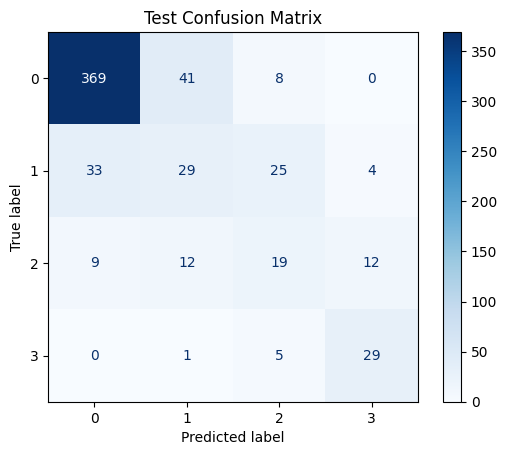

In [12]:

# ---------------------- Testing ----------------------
print("\n--- Running Test ---")
model.load_state_dict(torch.load("best_model_balanced.pth", map_location=device))
model.eval()

path_test = r"Cropped_ROIs_V0.47_Split\test_by_class"
y_true = []
y_pred = []

# Testing Loop
for label_str in os.listdir(path_test):
    label_dir = os.path.join(path_test, label_str)
    if not os.path.isdir(label_dir): continue
        
    true_label = int(label_str)
    
    for fname in os.listdir(label_dir):
        if not fname.endswith(('.png', '.jpg', '.jpeg')): continue
        
        img_path = os.path.join(label_dir, fname)
        
        # Load and Preprocess single image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.equalizeHist(img)
        
        # Use simple transform for inference (No Augmentation)
        transform = A.Compose([
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2()
        ])
        
        img_tensor = transform(image=img)["image"].unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)
            
        y_true.append(true_label)
        y_pred.append(pred.item())

# Metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.show()